<a href="https://colab.research.google.com/github/leticiarccorrea/sales-operations-demand-forecasting/blob/main/case_salesmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import dataset

from google.colab import drive
import pandas as pd


# Access to Google Drive
drive.mount('/content/drive')
datapah = '/content/drive/MyDrive/caseboti/dataset.csv'
datapah_dic = '/content/drive/MyDrive/caseboti/dicionariodedados.csv'


# Load file in pandas and spark
base = pd.read_csv(datapah, sep=';', on_bad_lines='warn')
base_dictionary = pd.read_csv(datapah_dic)

Mounted at /content/drive


In [2]:
base.head()

,COD_CICLO,FLG_DATA,COD_MATERIAL,COD_CANAL,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,COD_REGIAO,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,VL_RECEITA_LIQUIDA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,PCT_DESCONTO,VL_PRECO
0,201917,1,431148,anon_S0,anon_S2,anon_S3,anon_S1,"11934,000000",414.0,"431869,080000","431869,080000",0,0,0,0,0,NaN,"455,400000"
1,202005,0,177816,anon_S0,anon_S2,anon_S4,anon_S1,"540,000000",252.0,"27743,400000","27743,400000",0,0,0,0,0,NaN,"773,400000"
2,201901,0,171786,anon_S0,anon_S5,anon_S6,anon_S1,"54012,000000",1410.0,"962860,200000","962860,200000",0,1,0,0,0,"35,000000","341,400000"
3,201813,0,177774,anon_S7,anon_S2,anon_S8,anon_S1,"438,000000",NaN,"7608,600000","7608,600000",0,0,0,0,0,NaN,"450,900000"
4,202006,1,446592,anon_S0,anon_S5,anon_S9,anon_S1,"2760,000000",240.0,"83339,400000","83339,400000",0,0,0,0,0,NaN,"431,400000"


In [3]:
base.count()

,0
COD_CICLO,173923
FLG_DATA,173923
COD_MATERIAL,173923
COD_CANAL,173923
DES_CATEGORIA_MATERIAL,173923
DES_MARCA_MATERIAL,173923
COD_REGIAO,173923
QT_VENDA_BRUTO,173923
QT_DEVOLUCAO,87164
VL_RECEITA_BRUTA,173923


# Análise Exploratória e Descritiva (EDA)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

**1. Data cleaning e feature engineering**

In [5]:
# criando uma base para não alterar a original
import numpy as np
import pandas as pd

base_work = base.copy()

# converter colunas numéricas

# Define colunas numéricas
numeric_like_columns = [
    "QT_VENDA_BRUTO",
    "QT_DEVOLUCAO",
    "VL_RECEITA_BRUTA",
    "VL_RECEITA_LIQUIDA",
    "PCT_DESCONTO",
    "VL_PRECO",
]

def parse_ptbr_number(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        return series

    # Normaliza tokens ausentes e converte PT-BR - float
    return (
        series.astype(str)
        .str.strip()
        .replace(
            {
                "": np.nan,
                "nan": np.nan,
                "NaN": np.nan,
                "NULL": np.nan,
                "None": np.nan,
            }
        )
        .str.replace(".", "", regex=False)   # remove separador de milhar
        .str.replace(",", ".", regex=False)  # vírgula decimal -> ponto
        .astype(float)
    )

# aplicando na base
for col in numeric_like_columns:
    if col in base_work.columns:
        base_work[col] = parse_ptbr_number(base_work[col])

# Preencher desconto faltante com 0 (assimundo que não teve desconto)
if "PCT_DESCONTO" in base_work.columns:
    base_work["PCT_DESCONTO"] = base_work["PCT_DESCONTO"].fillna(0.0)

    # normalizar desconto para 0–1
    if base_work["PCT_DESCONTO"].max() > 1.0:
        base_work["PCT_DESCONTO"] = base_work["PCT_DESCONTO"] / 100.0

    # Clip de ajuste nos descontos negativos
    base_work["PCT_DESCONTO"] = base_work["PCT_DESCONTO"].clip(lower=0.0)

# Criar uma coluna de demanda líquida: qt vendida - qt devolvida
if "QT_DEVOLUCAO" in base_work.columns:
    base_work["QT_DEVOLUCAO"] = base_work["QT_DEVOLUCAO"].fillna(0.0)
else:
    base_work["QT_DEVOLUCAO"] = 0.0

base_work["qt_venda_liquida"] = base_work["QT_VENDA_BRUTO"] - base_work["QT_DEVOLUCAO"]

# % devolução
base_work["pct_devolucao"] = np.where(
    base_work["QT_VENDA_BRUTO"] > 0,
    base_work["QT_DEVOLUCAO"] / base_work["QT_VENDA_BRUTO"],
    np.nan,
)

# Features de tempo baseada no COD_CICLO (formato: YYYYCC)
base_work["ano"] = (base_work["COD_CICLO"] // 100).astype(int)
base_work["ciclo"] = (base_work["COD_CICLO"] % 100).astype(int)

# Criar colune de flag resumo de campanha
campaign_columns = [c for c in base_work.columns if c.startswith("FLG_CAMPANHA")]

# se não encontrar colunas, cria como 0
if len(campaign_columns) > 0:
    base_work["FLG_CAMPANHA_RESUMO"] = (
        base_work[campaign_columns]
        .fillna(0)
        .max(axis=1)
        .astype(int)
    )
else:
    base_work["FLG_CAMPANHA_RESUMO"] = 0

# 6) Checks finais
cols_to_describe = [c for c in numeric_like_columns if c in base_work.columns]
cols_to_describe += ["qt_venda_liquida", "pct_devolucao", "ano", "ciclo", "FLG_CAMPANHA_RESUMO"]

display(base_work[cols_to_describe].describe())
print("Rows:", len(base_work))
print("Share with campaign:", float(base_work["FLG_CAMPANHA_RESUMO"].mean().round(4)))


,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,VL_RECEITA_LIQUIDA,PCT_DESCONTO,VL_PRECO,qt_venda_liquida,pct_devolucao,ano,ciclo,FLG_CAMPANHA_RESUMO
count,1.739230e+05,173923.000000,1.739230e+05,1.739230e+05,173923.000000,173923.000000,1.739230e+05,173923.000000,173923.000000,173923.000000,173923.000000
mean,1.050377e+04,246.472968,6.475499e+05,6.421887e+05,0.066075,543.703809,1.025729e+04,0.153472,2019.067800,9.106541,0.326443
std,3.327551e+04,567.751683,2.790452e+06,2.780483e+06,0.110192,243.974723,3.311038e+04,0.278724,0.862823,5.122042,0.468913
min,2.345454e+02,0.000000,2.340600e+02,2.340600e+02,0.000000,234.060000,-3.030000e+03,0.000000,2018.000000,1.000000,0.000000
25%,3.960000e+02,0.000000,6.369720e+03,6.273450e+03,0.000000,389.400000,3.120000e+02,0.000000,2018.000000,5.000000,0.000000
50%,2.070000e+03,234.000000,6.738048e+04,6.663558e+04,0.000000,461.400000,1.914000e+03,0.007645,2019.000000,9.000000,0.000000
75%,8.634000e+03,270.000000,3.468348e+05,3.427422e+05,0.150000,593.400000,8.376000e+03,0.137273,2020.000000,14.000000,1.000000
max,1.865862e+06,31662.000000,2.292459e+08,2.292459e+08,0.350000,5539.620000,1.865862e+06,2.917012,2021.000000,18.000000,1.000000


Rows: 173923
Share with campaign: 0.3264


In [6]:
base_work.head()

,COD_CICLO,FLG_DATA,COD_MATERIAL,COD_CANAL,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,COD_REGIAO,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,...,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,PCT_DESCONTO,VL_PRECO,qt_venda_liquida,pct_devolucao,ano,ciclo,FLG_CAMPANHA_RESUMO
0,201917,1,431148,anon_S0,anon_S2,anon_S3,anon_S1,11934.0,414.0,431869.08,...,0,0,0,0.00,455.4,11520.0,0.034691,2019,17,0
1,202005,0,177816,anon_S0,anon_S2,anon_S4,anon_S1,540.0,252.0,27743.40,...,0,0,0,0.00,773.4,288.0,0.466667,2020,5,0
2,201901,0,171786,anon_S0,anon_S5,anon_S6,anon_S1,54012.0,1410.0,962860.20,...,0,0,0,0.35,341.4,52602.0,0.026105,2019,1,1
3,201813,0,177774,anon_S7,anon_S2,anon_S8,anon_S1,438.0,0.0,7608.60,...,0,0,0,0.00,450.9,438.0,0.000000,2018,13,0
4,202006,1,446592,anon_S0,anon_S5,anon_S9,anon_S1,2760.0,240.0,83339.40,...,0,0,0,0.00,431.4,2520.0,0.086957,2020,6,0


**2. Verificação de qualidade dos dados**

In [7]:
# Pontos faltantes
missing_rate = base_work.isna().mean().sort_values(ascending=False)
display(missing_rate.to_frame("missing_rate").head(15))

,missing_rate
COD_CICLO,0.0
FLG_DATA,0.0
COD_MATERIAL,0.0
COD_CANAL,0.0
DES_CATEGORIA_MATERIAL,0.0
DES_MARCA_MATERIAL,0.0
COD_REGIAO,0.0
QT_VENDA_BRUTO,0.0
QT_DEVOLUCAO,0.0
VL_RECEITA_BRUTA,0.0


Gráficos da distribuição da demanda

In [9]:
# separar a base agregada por ciclo
coverage = (
    base_work
    .groupby(["ano", "ciclo"], as_index=False)
    .agg(
        total_vendido=("qt_venda_liquida", "sum"),
        receita_liquida=("VL_RECEITA_LIQUIDA", "sum"),
        n_eventos=("qt_venda_liquida", "size"),
    )
    .sort_values(["ano", "ciclo"])
    .reset_index(drop=True)
)

# índice temporal contínuo
coverage["t"] = np.arange(len(coverage))

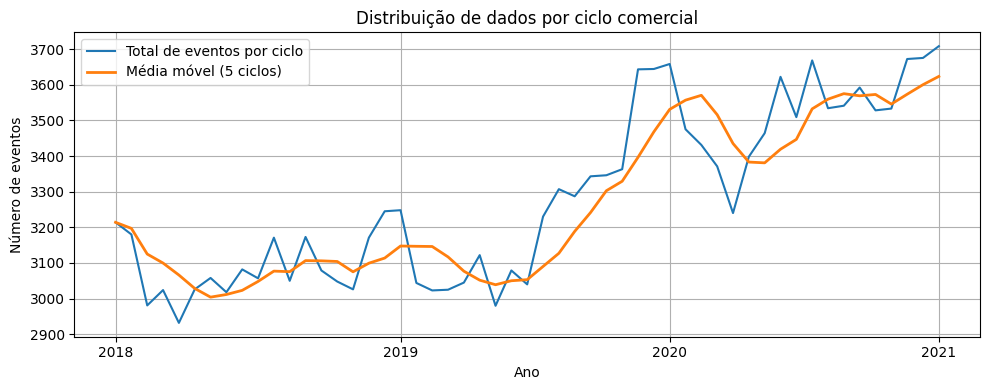

In [12]:
# gráfico da distribuição por pedidos
coverage = coverage.sort_values(["ano", "ciclo"]).reset_index(drop=True)
coverage["t"] = np.arange(len(coverage))

plt.figure(figsize=(10, 4))

plt.plot(
    coverage["t"],
    coverage["n_eventos"],
    label="Total de eventos por ciclo",
)

plt.plot(
    coverage["t"],
    coverage["n_eventos"].rolling(5, min_periods=1).mean(),
    linewidth=2,
    label="Média móvel (5 ciclos)",
)

# posições onde o ano muda
year_change_idx = coverage.index[coverage["ano"].ne(coverage["ano"].shift())]

# eixo X mostrando apenas os anos
plt.xticks(
    ticks=year_change_idx,
    labels=coverage.loc[year_change_idx, "ano"].astype(str),
)

plt.title("Distribuição de dados por ciclo comercial")
plt.xlabel("Ano")
plt.ylabel("Número de eventos")
plt.legend()
plt.tight_layout()
plt.show()

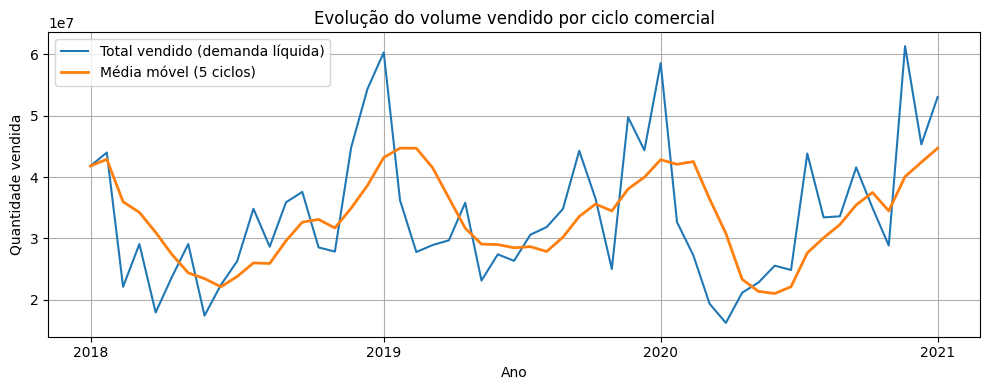

In [13]:
# gráfico 2 — Volume vendido por ciclo
plt.figure(figsize=(10, 4))

plt.plot(
    coverage["t"],
    coverage["total_vendido"],
    label="Total vendido (demanda líquida)",
)

plt.plot(
    coverage["t"],
    coverage["total_vendido"].rolling(5, min_periods=1).mean(),
    linewidth=2,
    label="Média móvel (5 ciclos)",
)

# posições onde o ano muda
year_change_idx = coverage.index[coverage["ano"].ne(coverage["ano"].shift())]

# eixo X mostrando apenas os anos
plt.xticks(
    ticks=year_change_idx,
    labels=coverage.loc[year_change_idx, "ano"].astype(str),
)

plt.title("Evolução do volume vendido por ciclo comercial")
plt.xlabel("Ano")
plt.ylabel("Quantidade vendida")
plt.legend()
plt.tight_layout()
plt.show()


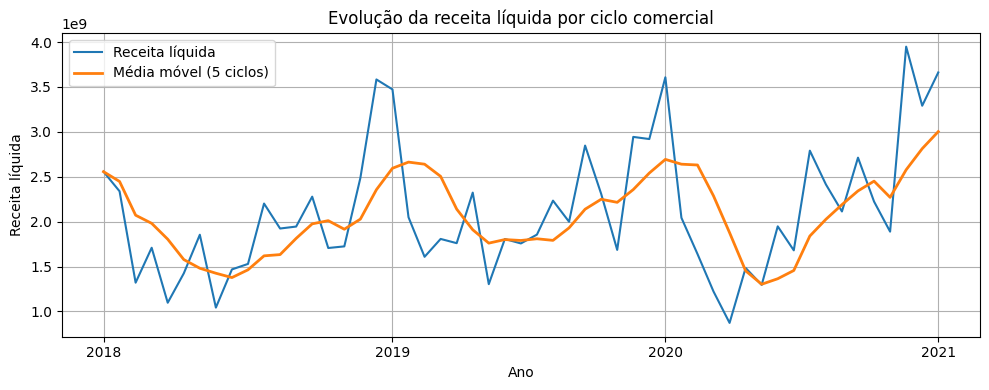

In [15]:
plt.figure(figsize=(10, 4))

plt.plot(
    coverage["t"],
    coverage["receita_liquida"],
    label="Receita líquida",
)

plt.plot(
    coverage["t"],
    coverage["receita_liquida"].rolling(5, min_periods=1).mean(),
    linewidth=2,
    label="Média móvel (5 ciclos)",
)

# posições onde o ano muda
year_change_idx = coverage.index[coverage["ano"].ne(coverage["ano"].shift())]

# eixo X mostrando apenas os anos
plt.xticks(
    ticks=year_change_idx,
    labels=coverage.loc[year_change_idx, "ano"].astype(str),
)

plt.title("Evolução da receita líquida por ciclo comercial")
plt.xlabel("Ano")
plt.ylabel("Receita líquida")
plt.legend()
plt.tight_layout()
plt.show()



**Verificação de qualidade dos dados**

In [16]:
# Verificações inválidas rápidas
invalid_negative = (base_work["qt_venda_liquida"] < 0).mean()
print("Share of rows with negative net demand:", round(float(invalid_negative), 6))

if "PCT_DESCONTO" in base_work.columns:
    print("Discount percentiles:", base_work["PCT_DESCONTO"].quantile([0.01, 0.5, 0.95, 0.99]).to_dict())


Share of rows with negative net demand: 0.000885
Discount percentiles: {0.01: 0.0, 0.5: 0.0, 0.95: 0.3116, 0.99: 0.35}


In [17]:
# investigando linhas negativas
neg_df = base_work.loc[base_work["qt_venda_liquida"] < 0].copy()

print("Negative rows:", len(neg_df))
print("Total negative net demand:", neg_df["qt_venda_liquida"].sum())
print("Share of total net demand (abs):",
      abs(neg_df["qt_venda_liquida"].sum()) / base_work["qt_venda_liquida"].sum())

display(
    neg_df[["COD_CICLO", "COD_MATERIAL", "QT_VENDA_BRUTO", "QT_DEVOLUCAO", "qt_venda_liquida"]]
    .sort_values("qt_venda_liquida")
    .head(20)
)


Negative rows: 154
Total negative net demand: -40134.0
Share of total net demand (abs): 2.249690142098999e-05


,COD_CICLO,COD_MATERIAL,QT_VENDA_BRUTO,QT_DEVOLUCAO,qt_venda_liquida
149783,202002,446904,3390.0,6420.0,-3030.0
15100,202014,455940,1446.0,4218.0,-2772.0
13602,202002,446904,1752.0,4422.0,-2670.0
88749,202011,466920,2082.0,4044.0,-1962.0
36297,202011,451242,1788.0,3612.0,-1824.0
140998,201911,444552,1260.0,2988.0,-1728.0
144683,201902,177840,3114.0,4470.0,-1356.0
135750,202014,451242,2016.0,3168.0,-1152.0
115826,202002,438678,1266.0,2388.0,-1122.0
41567,202014,455940,780.0,1794.0,-1014.0


In [18]:
base_work["has_discount"] = (base_work["PCT_DESCONTO"] > 0).astype(int)

base_work["discount_bucket"] = pd.cut(
    base_work["PCT_DESCONTO"],
    bins=[-0.001, 0.0, 0.10, 0.20, 0.30, 0.40, 1.0],
    labels=["0", "0-10%", "10-20%", "20-30%", "30-40%", "40%+"],
)

display(base_work["discount_bucket"].value_counts(dropna=False))


,count
discount_bucket,
0,123031
10-20%,24418
20-30%,13155
30-40%,10582
0-10%,2737
40%+,0


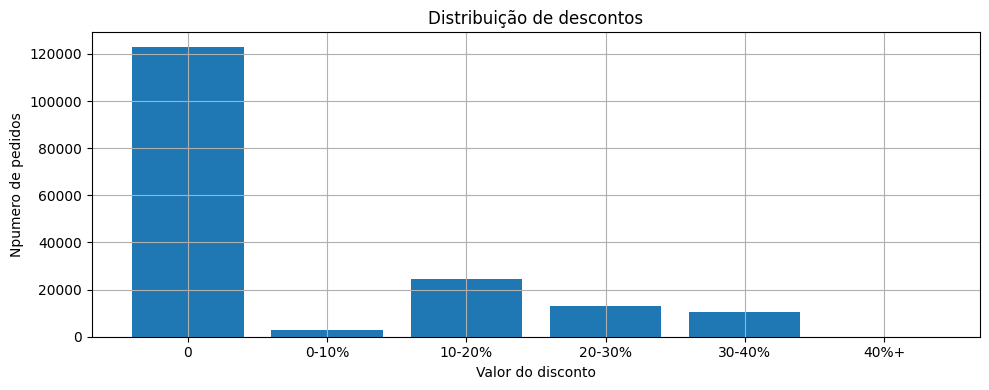

In [20]:
plt.figure(figsize=(10, 4))
bucket_counts = base_work["discount_bucket"].value_counts().sort_index()
plt.bar(bucket_counts.index.astype(str), bucket_counts.values)
plt.title("Distribuição de descontos")
plt.xlabel("Valor do disconto")
plt.ylabel("Npumero de pedidos")
plt.tight_layout()
plt.show()

A análise exploratória concentrou-se inicialmente em garantir a confiabilidade dos dados e a correta construção das métricas de negócio.

Foi realizada a conversão das colunas numéricas no formato brasileiro e criada a métrica de demanda líquida, que representa o sell-out efetivo ao considerar devoluções. As verificações de qualidade indicaram uma base consistente, com ocorrência residual de demanda negativa, explicada por efeitos operacionais de devolução, e sem evidências de problemas estruturais de dados.

Em seguida, os dados foram agregados por ciclo comercial, permitindo analisar a evolução temporal do volume vendido, da receita líquida e da quantidade de eventos.

Os gráficos mostraram estabilidade na cobertura dos dados ao longo dos anos e padrões claros de variação entre ciclos, com o uso de médias móveis para separar oscilações de curto prazo de movimentos mais estruturais.

Por fim, foi avaliado o comportamento dos descontos, que se mostrou altamente concentrado em zero, com poucos casos de descontos elevados. A criação de indicadores binários e faixas de desconto evidenciou que promoções são episódicas, porém relevantes para explicar picos de demanda e possíveis impactos na receita.